# Author  : Pathakota Surya Prakash Reddy
# Project: Finding Donors for Charity ML

# Exploring the Data
## Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, 'income', will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [24]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns


# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# Implementation: Data Exploration

# A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I had compute the following:

## The total number of records, 'n_records'
## The number of individuals making more than $50,000 annually, 'n_greater_50k'.
## The number of individuals making at most \$50,000 annually, 'n_at_most_50k'.
## The percentage of individuals making more than \$50,000 annually, 'greater_percent'.

In [2]:
records = data.shape[0]
n_greater_50k = len(data[data['income'] == '>50K'])
n_at_most_50k = len(data[data['income'] == '<=50K'])
greater_percent = 100 * n_greater_50k / records

print("Total number of records: ",records)
print("Individuals making more than $50,000:",n_greater_50k)
print("Individuals making at most $50,000: ",n_at_most_50k)
print("Percentage of individuals making more than $50,000: ",greater_percent)

Total number of records:  45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000:  34014
Percentage of individuals making more than $50,000:  24.78439697492371


# Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

# Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'.

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

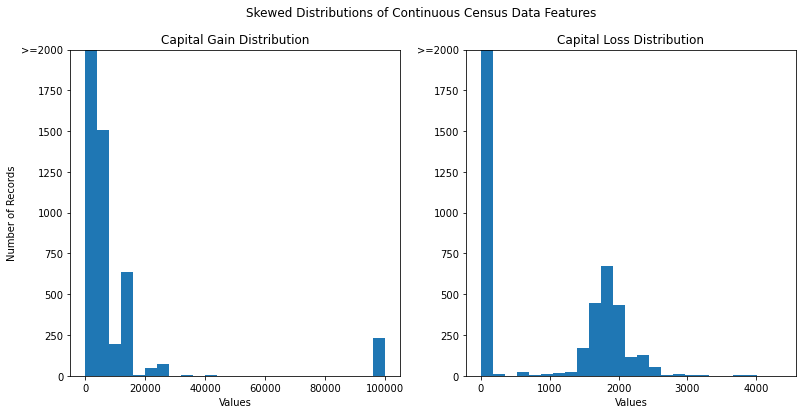

In [3]:
plt.figure(figsize = [13, 6])
base_color = sns.color_palette()[0]

labels = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
labels_names = ['0', '250', '500', '750', '1000', '1250', '1500', '1750', '>=2000']

plt.subplot(1, 2, 1)
plt.hist(data=data, x='capital-gain', bins=25)
plt.ylim(0, 2000)
plt.ylabel('Number of Records')
plt.xlabel('Values')
plt.title('Capital Gain Distribution')
plt.yticks(labels, labels_names)

plt.subplot(1, 2, 2)
plt.hist(data=data, x='capital-loss', bins=25)
plt.ylim(0, 2000)
plt.xlabel('Values')
plt.title('Capital Loss Distribution')
plt.yticks(labels, labels_names)

plt.suptitle('Skewed Distributions of Continuous Census Data Features');

For highly-skewed feature distributions such as 'capital-gain' and 'capital-loss', it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed.

In [4]:
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

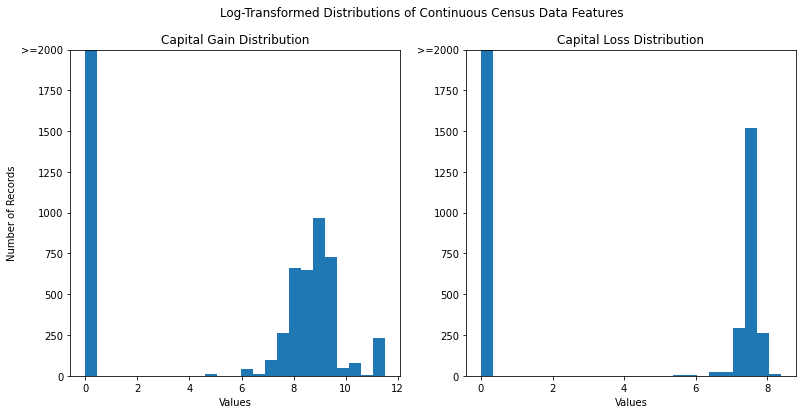

In [5]:
# Visualize the new log distributions
plt.figure(figsize = [13, 6])
base_color = sns.color_palette()[0]

labels = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
labels_names = ['0', '250', '500', '750', '1000', '1250', '1500', '1750', '>=2000']

plt.subplot(1, 2, 1)
plt.hist(data=features_log_transformed, x='capital-gain', bins=25)
plt.ylim(0, 2000)
plt.ylabel('Number of Records')
plt.xlabel('Values')
plt.title('Capital Gain Distribution')
plt.yticks(labels, labels_names)

plt.subplot(1, 2, 2)
plt.hist(data=features_log_transformed, x='capital-loss', bins=25)
plt.ylim(0, 2000)
plt.xlabel('Values')
plt.title('Capital Loss Distribution')
plt.yticks(labels, labels_names)

plt.suptitle('Log-Transformed Distributions of Continuous Census Data Features');

# Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use sklearn.preprocessing.MinMaxScaler for this.

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


# Implementation: Data Preprocessing
From the table in Exploring the Data above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature. 
Additionally, as with the non-numeric features, we need to convert the non-numeric target label, 'income' to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as 0 and 1, respectively. In code cell below, you will need to implement the following:

Use pandas.get_dummies() to perform one-hot encoding on the 'features_log_minmax_transform' data.
Convert the target label 'income_raw' to numerical entries.
Set records with "<=50K" to 0 and records with ">50K" to 1.

In [7]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded
features_final.head(5)

103 total features after one-hot encoding.


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Shuffle and Split Data
Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


# Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a naive predictor.

# Metrics and the Naive Predictor
CharityML, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that does not make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is more important than the model's ability to recall those individuals. We can use F-beta score as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$
In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the F$_{0.5}$ score (or F-score for simplicity).



 Accuracy measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

Precision tells us what proportion of messages we classified as spam, actually were spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

[True Positives/(True Positives + False Positives)]

Recall(sensitivity) tells us what proportion of messages that actually were spam were classified by us as spam. It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

[True Positives/(True Positives + False Negatives)]

# Question 1 - Naive Predictor Performace

In [9]:
# TODO: Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0
precision = float(TP)/(TP+FP)
recall = float(TP)/(TP+FN)
accuracy = float(TP+TN)/(TP+FP+FN+TN)
beta = 0.5
# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + beta ** 2)*(precision * recall)/(beta ** 2 *precision + recall)

# Print the results 
print("Preceision: {:.4f} \nRecall: {:.4f}".format(precision, recall))
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Preceision: 0.2478 
Recall: 1.0000
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


# Supervised Learning Models
From the supervised learning models that are currently available in scikit-learn that are choose from:

Gaussian Naive Bayes (GaussianNB), Decision Trees, Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting), 
K-Nearest Neighbors (KNeighbors), Stochastic Gradient Descent Classifier (SGDC), Support Vector Machines (SVM), Logistic Regression

# Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

Describe one real-world application in industry where the model can be applied.
What are the strengths of the model; when does it perform well?
What are the weaknesses of the model; when does it perform poorly?
What makes this model a good candidate for the problem, given what you know about the data?

I have selected Decision Tree, Support Vector Machine and Adaboost as supervised learners. Let’s summarize their strengths and weakness and observe the results.
# Decision Trees
In decision analysis, one of the visual and explicit representation of decision and decision making procedure can be performed by using decision trees. The decision tree is using a tree-like model of decisions such that a flowchart like tree structure in which each node internal node denotes a test and each branch represents an outcome of the test and each leaf node holds a corresponding class label. Decision tree is the one of the most powerful and popular tool for classification and prediction. Decision trees are commonly using in medical diagnosis, failure prediction, credit scoring and crime risk investigation. Several business analysis examples can be found but one of the widely used one is the detection of the fraudulent Financial Statements.
## Strengths
- Decision trees are able to handle both continuous and categorical variables.
- Decision trees provide a clear indication of which fields are most important for prediction or classification.
- Decision trees are able to generate understandable rules.
- Non-linear relationships between parameters do not affect tree performance.
- It can also be used in data exploration stage, such as we can create new variables / features that has better power to predict target variable.
- It requires less data cleaning compared to some other modeling techniques. It is not influenced by outliers and missing values to a fair degree.
- This means that decision trees have no assumptions about the space distribution and the classifier structure
## Weakness
- Over fitting is one of the most practical difficulty for decision tree models. This problem gets solved by setting constraints on model parameters and pruning.
- While working with continuous numerical variables, decision tree loses information, when it categorizes variables in different categories.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
- Decision trees are prone to errors in classification problems with many class and relatively small number of training examples.
- Decision tree can be computationally expensive to train. The process of growing a decision tree is computationally expensive. At each node, each candidate splitting field must be sorted before its best split can be found.
# Support Vector Machine
The working principle of the support vector machines is to find or create the hyperplane in an N-dimensional space that distinctly classifies the data points. The dimension of the hyperplane is depending on the number of the features. Hyperplane is basically the decision boundaries that helps the classification of the data such that data points which are locating at te different side of the hyperplane are classified as different classes. Support vector machines are commonly used in face detection, text and hypertext categorization, classification of images, bioinformatics and, handwriting recognition. One of the real world example is performed in the article “Application of support vector machine modeling for prediction of common diseases: the case of diabetes and pre-diabetes”.
## Strengths
- The usage of a regularization parameter provides avoiding from over-fitting.
- The kernel trick provides an expert knowledge about the problem via engineering the kernel.
- Approximation helps to create a bound on the test error rate.
## Weakness
- Despite the avoiding from over-fitting by optimizing the parameters to model selection, kernel model is quite sensitive to over-fitting. Therefore selection of the kernel function is the most important feature and weakness of the SVM.
- Training with large dataset can be time consuming.
# AdaBoost
AdaBoost, which is the abbreviation of the Adaptive Boosting, is the first practical boosting algorithm proposed by Freund and Schapire in 1996. AdaBoost is an algorithm for constructing a “strong” classifier as linear combination of “simple” “weak” classifier. In other words, the main working principle is to convert a set of weak classifiers into a strong one. Weak classifier is described as less than 50% error over any distribution and strong classifier is threshold linear combination of the weak classifier outputs.
## Strengths
- The implementation of the algorithm is simple.
- The feature selection is done which resulting in relatively simple classifier.
- Good generalization can be provided.
## Weakness
- Algorithm is sensitive to the noisy data and the outliers.
- The provided solution can be the sub-optimal solution.
- Algorithm may not handle with the increasing complexity.
- Since decision tree is performing feature selection inside the original algorithm as stated in strengths points, then it can be a good candidate for our problem. In addition, Decision tree algorithm can be chosen when the speed is the focus point.
- Support vector machine can be a good candidate for our problem as accuracy point of view. Even if we noted the over-fitting problem of the SVM, it is still a good candidate since our dataset is not provided in noisy content.
- As stated in the weakness part, AdaBoost classifier is sensitive to noisy data, however in our case our dataset is provided in clear format. Then Adaboost is a good candidate because of its simplest implementation. In addition to its simpler implementation, AdaBoost will provide a good generalization for our problem.

# Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we’ve chosen, it’s important that you create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.
Let’s create a training and predicting function

In [25]:
from sklearn.metrics import fbeta_score, accuracy_score

In [14]:
from time import time
def evaluate(model,sample_size,X_train,y_train,X_test,y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results={}
    start=time()
    model=model.fit(X_train[:sample_size],y_train[:sample_size])
    end=time()
    results['train_time']=end-start
    # Prediction on Testing DataSets
    start=time()
    predictions_test=model.predict(X_test)
    predictions_train=model.predict(X_train[:300])
    end=time()
    
    results['pred_time']=end-start
    
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
    print("{} trained on {} samples.".format(model.__class__.__name__, sample_size))
    return results

Now, let’s observe the initial model evaluation and results

In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

clf_SVC=SVC(random_state=40)
clf_ADA=AdaBoostClassifier(random_state=15)
clf_RAN=RandomForestClassifier(random_state=3)

samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

results = {}
for clf in [clf_SVC, clf_ADA, clf_RAN]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        evaluate(clf, samples, X_train, y_train, X_test, y_test)

SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


In [17]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 4, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Set additional plots invisibles
    ax[0, 3].set_visible(False)
    ax[1, 3].axis('off')

    # Create legend
    for i, learner in enumerate(results.keys()):
        plt.bar(0, 0, color=colors[i], label=learner)
    plt.legend()
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()
    

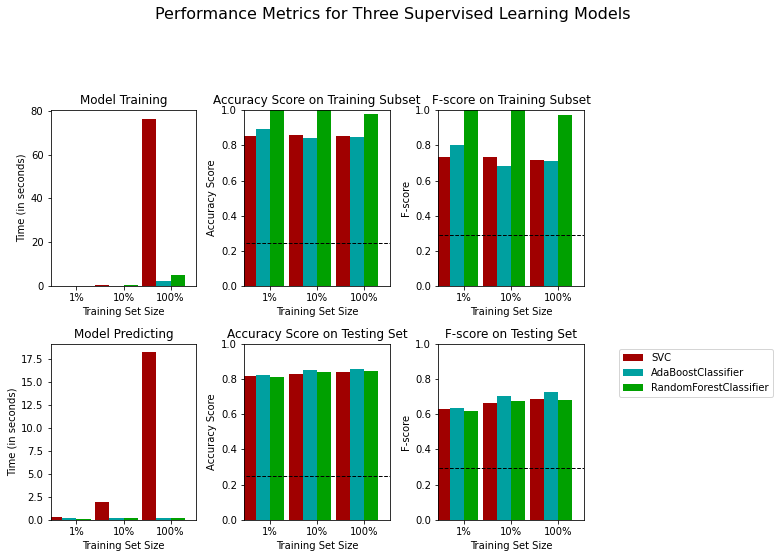

In [18]:
evaluate(results, accuracy, fscore)

As already said we are focusing on the model’s ability to precisely predict those that make more than $50000 which is more important than the model’s ability to recall those individuals. AdaBoostClassifier is the one that performs best on the testing data, in terms of both the Accuracy and F-score. Moreover AdaBoostClassifier is also pretty fast to train as shown int the Time-Training_set_size histogram
Now we will fine tune the model using sklearn.grid_search.GridSearchCV

In [19]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Initialize the classifier
clf = AdaBoostClassifier(random_state=7)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': [50, 100, 200],
             'learning_rate': [1.0, 2.0]}

# Make an fbeta_score scoring object using make_scorer()
scorer=make_scorer(fbeta_score,beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\surya\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8651
Final F-score on the testing data: 0.7396


Finally we can find out which are the features that provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon. We can do that using feature_importance_


In [20]:

# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

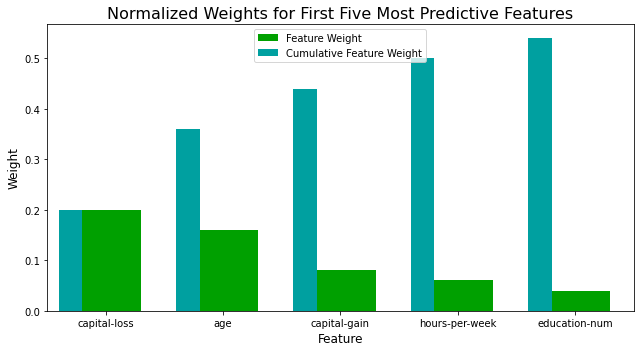

In [21]:
# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]

    # Creat the plot
fig = plt.figure(figsize = (9,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', 
        label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', 
        label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)
    
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()  

According to the features provided by AdaBoost as seen in above plot, my predictions are partially satisfied. I am not expected that capital-loss and capital-gain is inside the most important five feature. Age is one feature that I am not sure about including it or not. I thought that age can be included in the education level and it seems it is the opposite. Since education level does not affect the income as I thought. In addition for the occupancy, it was my second important feature but it is not involved. My guess is occupancy is also included in age. It can be said that I was only close to hour-per-week feature.
Let’s see the observe the result of the model by performing the feature selection.

In [22]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8651
F-score on testing data: 0.7396

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6920


It is obviously seen that the feature selection results in decrease in accuracy and f-score. I think, it may be due to the decrease in complexity. The algorithm is not understand the complexity of the dataset with the 5 features and cannot make the generalization in a best way. However, the effects on the accuracy and f-score are quite acceptable by comparing the effect of the training time. If the training time is an important factor, reducing the data is a price to pay that I can take.